# Named Entites in Video Game Texts
***
By [Alejandro Ciuba](https://alejandrociuba.github.io), alc307@pitt.edu
***
## Summary
In this notebook, I will be examining the following:
1. What named entites are common in video games?
2. Are named entites common in video games?
3. Are there trends in named-entity types across games?
4. A brief look at hapaxes in named entities.

All of this is on a _"gotten-data-level"_, while I suspect many things found here may apply to video games as a whole, broad assumptions relating to this topic requires more data.

### Content
1. [Named Entities](#named-entities)
2. [Named-Entity Hapaxes](#hapaxes)
***
## Python Imports

In [1]:
# Necessary imports
import spacy

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import pickle as pkl

import notebook_funcs.notebook as nf

### Settings

In [2]:
# Settings
# I looked this up so everything is prettier
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

# Use display(dataframe) to show

%pprint

Pretty printing has been turned OFF


### Useful Functions
All functions used in this notebook are defined in either `notebook_funcs/notebook.py` or `specific_funcs.specific.py`. Please consult these scripts to see exactly how the functions work behind-the-scenes.

### Data-Importing

In [3]:
# Bringing in the dataframes
FILEPATH = "../private/pickled_dfs/"

es_df = pd.read_pickle(FILEPATH + "elder_scrolls.pkl")
hk_df = pd.read_pickle(FILEPATH + "hollow_knight.pkl")
kotor_df = pd.read_pickle(FILEPATH + "kotor.pkl")
tl_df = pd.read_pickle(FILEPATH + "torchlight.pkl")

# All dfs stored in a simple list
datasets = [es_df, hk_df, kotor_df, tl_df]

### Document Set-Up

In [4]:
# Load the standard en_core_web transformer
nlp = spacy.load("en_core_web_trf")

In [5]:
# Load the pickled list
if True:
    with open('../private/pickled_docs/docs.pkl', 'rb') as src:
        docs = pkl.load(src)
        elder_scrolls_doc = docs[0]
        hollow_knight_doc = docs[1]
        kotor_doc = docs[2]
        torchlight_doc = docs[3]

### Dictionary

In [6]:
# Zip them together in one dictionary, first index is the dataframe, the second is the doc object generated by spaCy
data = {game: [df, doc] for (game, df, doc) in zip(["TES Books", "Hollow Knight", "KOTOR", "Torchlight II"], datasets, docs)}

***
## Named Entities
For this, I will be using _spaCy_ and its standard _"en\_core\_web\_trf"_ model. While it is an AI model, its named-entity tagger accuracy is [estimated to be around 90%](https://spacy.io/usage/facts-figures#benchmarks). I will also be taking only samples of `kotor_df` and `elder_scrolls_df` as their full texts are too big to be loaded onto one _spaCy_ model. Additionally, these models will base themselves off of the pure text of the dataframes, with no additional information. This is because, due to the fact I will be relying on named entity recognition, other data (author, character, listener, etc.) might (will) be mistaken as a named entity in the sentences. Furthermore, I am only interested in the named entities in the texts themselves, not outside sources.

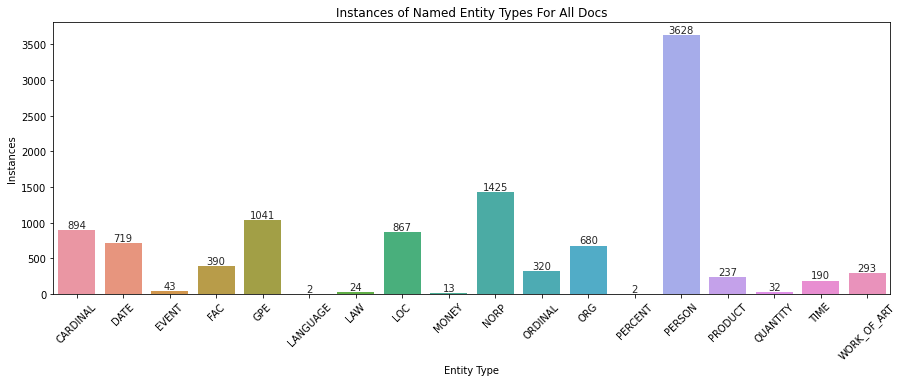

In [7]:
# Let's create a dictionary to keep track of the named-entity types we see
entities = {label: 0 for label in nlp.get_pipe('ner').labels}

for doc in docs:
    for ent in doc.ents:
        entities[ent.label_] += 1

plt.figure(figsize=(15,5))
nf.barplot(x=list(entities.keys()), y=list(entities.values()), title="Instances of Named Entity Types For All Docs", xlabel="Entity Type", ylabel="Instances", xtickrot=45)

Let's create a dataframe which will contain the following information:

| Column | Data |
| ------ | ---- |
| `entity` | Name of the entity |
| `tag` | Entity Tag as given by _spaCy_ |
| `source` | Game from which it came |

This will be useful for graphing more detailed charts as well as exploring hapaxes.

In [8]:
# Dataframe creation
entities_df = pd.DataFrame({'entity':[], 'tag': [], 'source': []})

# Loop through all the documents
for game in data:
    for ent in data[game][1].ents:
        entities_df = entities_df.append({'entity': ent.text, 'tag': ent.label_, 'source': game}, ignore_index=True)

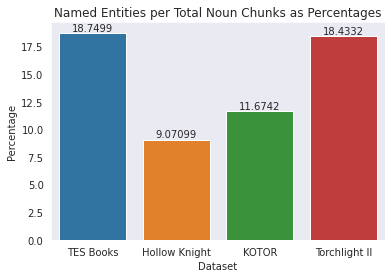

In [9]:
# Let's graph their frequencies
ent_counts = entities_df['source'].value_counts()
chunk_counts = [(len(list(data[game][1].noun_chunks)), game) for game in data]
percentages = [ent_counts[game] / total_chunks * 100 for (total_chunks, game) in chunk_counts]

nf.barplot(x=list(data.keys()), y=percentages, title='Named Entities per Total Noun Chunks as Percentages', xlabel="Dataset", ylabel="Percentage")

plt.show()

Something interesting to note is that it lumps holidays/festivals (_Witches' Festival_, _Jester's Day_, etc.) into `ORG` (organizations) and [there is not a specific tag for holidays/festivals](https://spacy.io/api/annotation). There's also some mistakes (_Day_ being called a `PERSON`), but I will assume the errors are small and continue.

In [10]:
# Graph entities by type and game
# Creat stacked Series
entities_info = entities_df.groupby('tag').source.value_counts() # Never understood why this is a Series.

# Replace 'NaN's with 0
display(entities_info.unstack(fill_value=0)) # Wow

source,Hollow Knight,KOTOR,TES Books,Torchlight II
tag,,,,
CARDINAL,136,10,682,66
DATE,10,12,648,49
EVENT,2,0,38,3
FAC,42,8,235,105
GPE,58,13,869,101
LANGUAGE,0,1,1,0
LAW,1,1,22,0
LOC,41,13,539,274
MONEY,1,8,4,0


Let's look at the word _"Cyrodiilic"_ in context.

In [11]:
for text in nf.concordances(es_df, phrase=r'Cyrodiilic', col='text', context_cols=['author', 'title'], sides=40):
    print(text)

Author: Anonymous | Title: monomyth-cyrodiilic-shezarrs-song | Concordance:
	...Note: This part was known as the CYRODIILIC Creation Myth....
Author: Waughin Jarth | Title: wolf-queen-v1 | Concordance:
	...The documents were well organized by year, province, and kingdom, and it took Potema only a short while to find the Promise of Marriage between Uriel Septim II, by the Grace of the Gods, Emperor of the Holy CYRODIILIC Empire of Tamriel and his daughter the Princess Galana, and His Majesty King Mantiarco of Solitude. She grabbed her prize and was out of the Hall with the door well-locked before the page was even in sight....
Author: Rallaume Lemonds, Culinary Crusader | Title: culinary-adventure-volume-2 | Concordance:
	...small reed enclosures that each house hundreds of caterpillars. I was shocked by the sheer variety. I saw long caterpillars, fat caterpillars, orange and purple-striped caterpillars—I've never seen such diversity! I asked a few questions, but Mach-Makka's limited ma

As you can see, _toponynms_ are an issue.

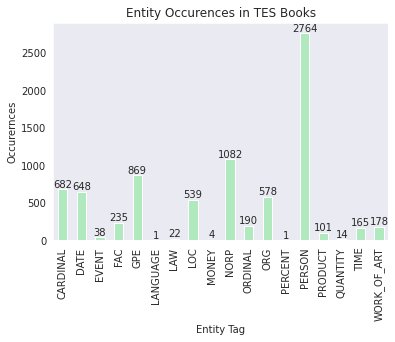

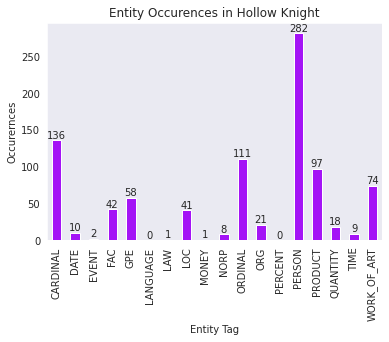

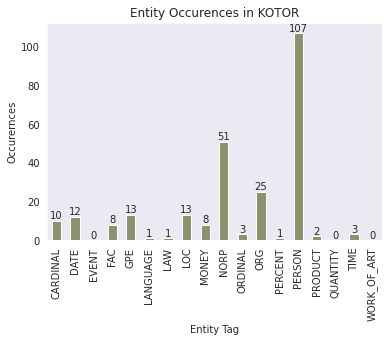

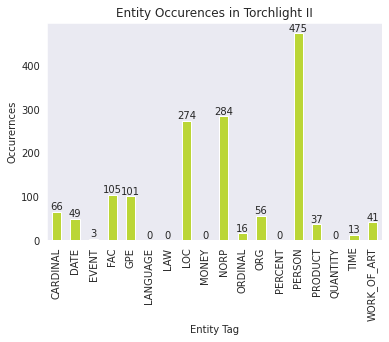

In [12]:
# Now let's actually graph it per game!
# Graph for all games
for game in data:
    ax = entities_info.unstack().plot.bar(stacked=True, y=game, xlabel='Entity Tag', ylabel='Occurernces'
                                        , legend=False, title='Entity Occurences in ' + game, color=np.random.rand(3), rot=90)
    plt.bar_label(ax.containers[0])
    plt.show()

These aren't the prettiest, but they do accurately highlight the proportion of named entity types per video game. The most common named entity, by far, seems to be `PERSON` for all games, followed by `NORP` in most cases.

**NOTE:** When I used the `en_core_web_sm` model, the most popular tag was an unrivaled `ORG` for all games, followed by `PERSON`. An interesting change and I believe this new data is more accurate.
***
## Hapaxes
Unfortunately, we can only use the named entities from _Hollow Knight_ and _Torchlight II_ because, as you recall, the data from _KOTOR_ and _TES Books_ were only samples. This means that a lot of hapaxes documented in there are not actually hapaxes. I originally discovered this issue through examining the _KOTOR_ data looking at the word "Hutt" which consistently appeared as a hapax in randomly sampled data, but was not, in fact, a hapax.

In [13]:
# HOLLOWKNIGHT DATA BIAS - EXTRANEOUS TEXT
hapaxes_hk = entities_df[entities_df['source'] == 'Hollow Knight'].entity.value_counts()
hapaxes_hk = hapaxes_hk[hapaxes_hk == 1]
display(hapaxes_hk.sample(10))

hapaxes_tl = entities_df[entities_df['source'] == 'Torchlight II'].entity.value_counts()
hapaxes_tl = hapaxes_tl[hapaxes_tl == 1]
display(hapaxes_tl.sample(10))

hapaxes = [hapaxes_hk, hapaxes_tl]

four                             1
After Black Egg is               1
Thirty-Six                       1
Precept Forty-Eight              1
Wai                              1
Ages                             1
The White Saviour in Darkness    1
Forty-Two                        1
King's Brand                     1
Twenty-Four                      1
Name: entity, dtype: int64

the Mask of a Murderer    1
five hundred years        1
the Warbeast Den          1
millions                  1
the past few hours        1
Alas                      1
the Grand Regent          1
the Heartfire Stone       1
that Power Source         1
Trillbot 4000.Oh          1
Name: entity, dtype: int64

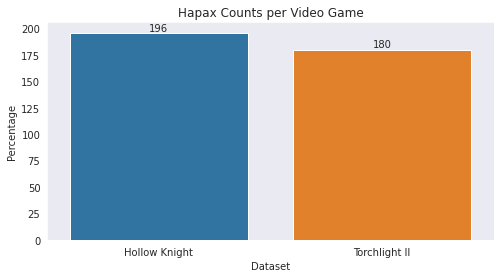

In [14]:
plt.figure(figsize=(8,4))
nf.barplot(x=["Hollow Knight", "Torchlight II"], y=[len(series) for series in hapaxes], title='Hapax Counts per Video Game', xlabel="Dataset", ylabel="Percentage")
plt.show()

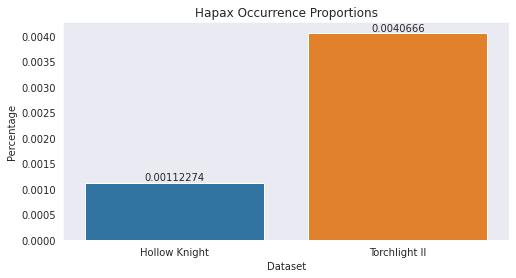

In [15]:
plt.figure(figsize=(8,4))
nf.barplot(x=["Hollow Knight", "Torchlight II"], y=[len(series)/len(docs[ind]) for (ind, series) in enumerate(hapaxes)]
        , title='Hapax Occurrence Proportions', xlabel="Dataset", ylabel="Percentage")
plt.show()